# Experimentation Notebook for Single Documents

Will be used for experimenting various methods on individual documents. Methods will be abstracted

### Document Breakup

In [2]:
import helper
import docx

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
import re

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/virajkacker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
def get_sentences(file_path):
    # Load the document
    doc = docx.Document(file_path)

    # Iterate over each paragraph in the document
    sentences = []
    for para in doc.paragraphs:
        # Split the paragraph into sentences
        for sent in nltk.sent_tokenize(para.text):
            # Append the sentence to the list
            sentences.append(sent)
    
    return sentences

In [6]:
file_path = '../congress_report/18th-CCP-Congress-Report.docx'

In [7]:
# Paragraphs
paragraphs = helper.get_paragraphs(file_path)

In [8]:
# Split paragraphs into sentences
sentences = get_sentences(file_path)

### Data Cleaning Methods

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

In [10]:
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z]', ' ', text)

    # Tokenize text and remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatize each word
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Remove short words (less than 3 characters)
    words = [word for word in words if len(word) > 2]

    return ' '.join(words)

In [11]:
cleaned_sentences = [clean_text(sent) for sent in sentences]
# Remote all '' from the cleaned_paragraphs 
cleaned_sentences = [para for para in cleaned_sentences if para != '']

In [37]:
cleaned_paragraphs = [clean_text(para) for para in paragraphs]
# Remote all '' from the cleaned_paragraphs 
cleaned_paragraphs = [para for para in cleaned_paragraphs if para != '']

### BERT Topic Test

In [34]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(cleaned_sentences, show_progress_bar=True)

.gitattributes: 100%|██████████| 1.18k/1.18k [00:00<00:00, 832kB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 182kB/s]
README.md: 100%|██████████| 10.6k/10.6k [00:00<00:00, 7.71MB/s]
config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 90.1kB/s]
data_config.json: 100%|██████████| 39.3k/39.3k [00:00<00:00, 18.8MB/s]
pytorch_model.bin: 100%|██████████| 438M/438M [00:31<00:00, 13.9MB/s] 
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 18.0kB/s]
special_tokens_map.json: 100%|██████████| 239/239 [00:00<00:00, 122kB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 13.9MB/s]
tokenizer_config.json: 100%|██████████| 363/363 [00:00<00:00, 127kB/s]
train_script.py: 100%|██████████| 13.1k/13.1k [00:00<00:00, 4.07MB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 17.2MB/s]
Batches: 100%|██████████| 27/27 [00:10<00:00,  2.57it/s]


In [40]:
from umap import UMAP
from hdbscan import HDBSCAN

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=20, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [41]:
# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

In [42]:
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, TextGeneration

# KeyBERT
keybert = KeyBERTInspired()

# MMR
mmr = MaximalMarginalRelevance(diversity=0.3)

# Text generation with Llama 2
# llama2 = TextGeneration(generator, prompt=prompt)

# All representation models
representation_model = {
    "KeyBERT": keybert,
    # "Llama2": llama2,
    "MMR": mmr,
}

In [43]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,
)

# Train model
topics, probs = topic_model.fit_transform(cleaned_sentences, embeddings)

### Sentinment ANalysis

In [3]:
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/virajkacker/nltk_data...


True

In [13]:
sia = SentimentIntensityAnalyzer()


In [14]:
for sentence in sentences:  # Assuming 'sentences' is your list of sentences
    sentiment = sia.polarity_scores(sentence)
    print(f"Sentence: {sentence}")
    print(f"Sentiment: {sentiment}\n")

Sentence: HU JINTAO
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Sentence: REPORT TO THE 18TH NATIONAL CONGRESS OF THE COMMUNIST PARTY OF CHINA
Sentiment: {'neg': 0.0, 'neu': 0.803, 'pos': 0.197, 'compound': 0.4019}

Sentence: Firmly March on the Path of Socialism with Chinese Characteristics and Strive to Complete the Building of a Moderately Prosperous Society In All Respects
Sentiment: {'neg': 0.0, 'neu': 0.795, 'pos': 0.205, 'compound': 0.6597}

Sentence: http://www.china.org.cn/china/18th_cpc_congress/2012-11/16/content_27137540.htm
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Sentence: (Delivered on November 8, 2012)
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Sentence: Hu Jintao
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Sentence: Comrades,
Sentiment: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Sentence: I now wish to deliver the following report to the Eighteenth National Congress 

### Named Entity Recognition

In [30]:
import spacy
from collections import defaultdict


In [20]:
nlp = spacy.load("en_core_web_sm")


In [22]:
def get_full_text(file_path):
    # Load the document
    doc = docx.Document(file_path)

    # Extract text from each paragraph and concatenate
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)

    # Join all paragraphs text into a single string
    full_text = '\n'.join(full_text)
    
    return full_text

In [27]:
document_text = get_full_text(file_path)  # 'document_text' is your full document as a single string


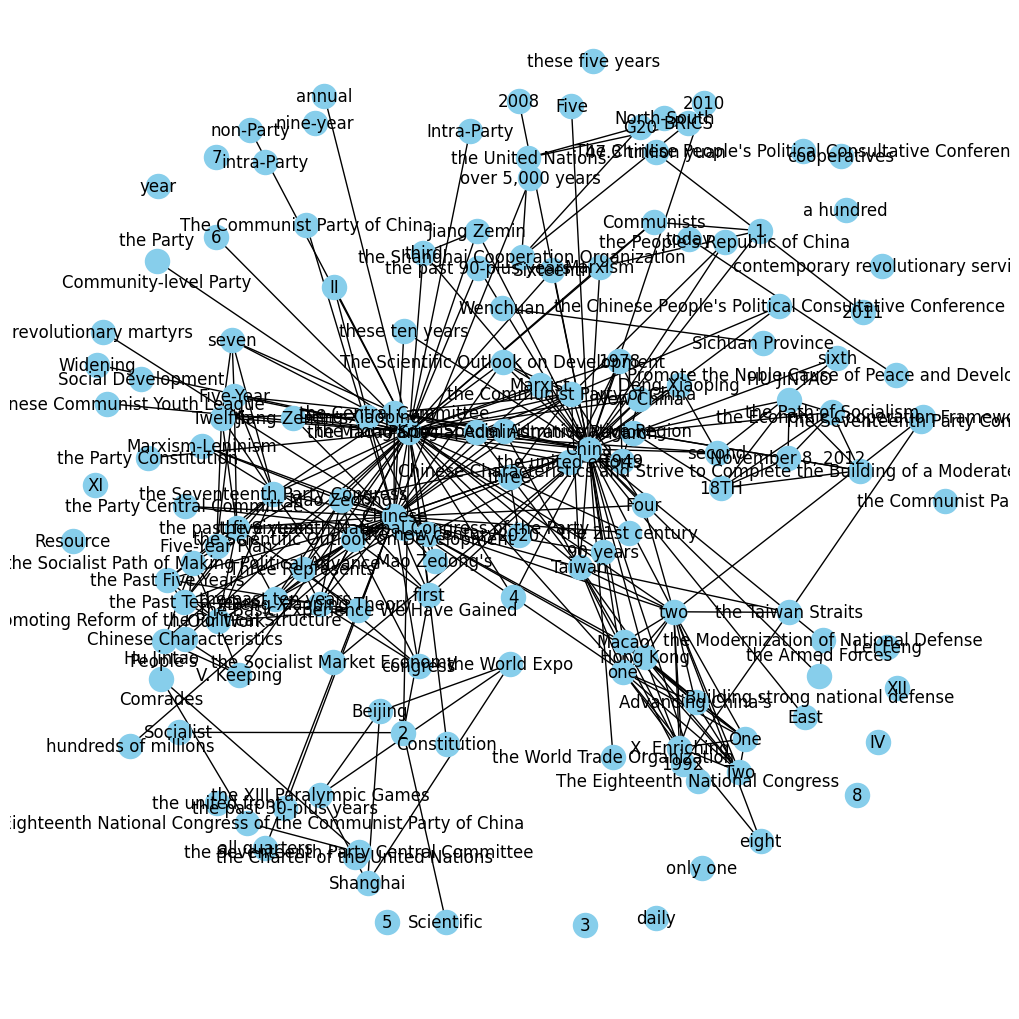

In [33]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Process your text
doc = nlp(document_text)

# Create a graph
G = nx.Graph()

# Add nodes and edges
for sent in doc.sents:
    entities = [ent.text for ent in sent.ents]
    for entity in entities:
        G.add_node(entity)
    for entity1 in entities:
        for entity2 in entities:
            if entity1 != entity2:
                G.add_edge(entity1, entity2)

# Draw the graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, k=0.5)  # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()